In [54]:
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [55]:
base_dir = r"D:\desktop\python\algaenet\dataset\train"
image_dir = os.path.join(base_dir, "images")
label_dir = os.path.join(base_dir, "labels")

In [56]:
class_names = {
    0: "Platymonas",
    1: "Chlorella",
    2: "Dunaliella_salina",
    3: "Effrenium",
    4: "Porphyridium",
    5: "Haematococcus"
}

In [57]:
for class_id, class_name in class_names.items():
    class_subdir = os.path.join(image_dir, class_name)
    os.makedirs(class_subdir, exist_ok=True)
    print(f"created or found directory- {class_subdir}")

created or found directory- D:\desktop\python\algaenet\dataset\train\images\Platymonas
created or found directory- D:\desktop\python\algaenet\dataset\train\images\Chlorella
created or found directory- D:\desktop\python\algaenet\dataset\train\images\Dunaliella_salina
created or found directory- D:\desktop\python\algaenet\dataset\train\images\Effrenium
created or found directory- D:\desktop\python\algaenet\dataset\train\images\Porphyridium
created or found directory- D:\desktop\python\algaenet\dataset\train\images\Haematococcus


In [58]:
moved_count = 0
skipped_count = 0
error_count = 0

print(f"\nprocessing labels in- {label_dir}")
if not os.path.exists(label_dir):
    print(f"error- label directory not found at {label_dir}")
else:
    label_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]
    print(f"found {len(label_files)} label files")

    for label_file in label_files:
        label_path = os.path.join(label_dir, label_file)
        image_name = label_file.replace(".txt", ".jpg") 
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            # print(f"skipping- image file not found for label {label_file} at {image_path}")
            skipped_count += 1
            continue

        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()
                if not lines:
                    # print(f"warning- label file {label_file} is empty")
                    skipped_count += 1
                    continue

                first_line = lines[0].strip()
                if not first_line: 
                     skipped_count += 1
                     continue

                parts = first_line.split()
                if not parts:
                    skipped_count += 1
                    continue

                class_id = int(parts[0])
                class_name = class_names.get(class_id)

                if class_name:
                    destination_dir = os.path.join(image_dir, class_name)
                    destination_path = os.path.join(destination_dir, image_name)

                    # check if file already moved 
                    if not os.path.exists(destination_path):
                         shutil.move(image_path, destination_path)
                         # print(f"Moved {image_name} to {destination_dir}")
                         moved_count += 1
                    else:
                         # print(f"skipping- {image_name} already in {destination_dir}")
                         # if the original image file still exists somehow, remove it
                         if os.path.exists(image_path):
                             os.remove(image_path)
                         skipped_count +=1

                else:
                    print(f"warning- unknown class ID {class_id} in {label_file}")
                    error_count += 1

        except Exception as e:
            print(f"error processing file {label_file}- {e}")
            error_count += 1

print(f"\nfinished processing")
print(f"moved {moved_count} images")
print(f"skipped {skipped_count} images (not found, empty label, already moved, or empty lines)")
print(f"encountered {error_count} errors (unknown class ID or file processing issues)")


processing labels in- D:\desktop\python\algaenet\dataset\train\labels
found 700 label files

finished processing
moved 0 images
skipped 700 images (not found, empty label, already moved, or empty lines)
encountered 0 errors (unknown class ID or file processing issues)


In [59]:
print("\nverifying directory structure")
for item in os.listdir(image_dir):
    item_path = os.path.join(image_dir, item)
    if os.path.isdir(item_path):
        print(f" - directory- {item} contains {len(os.listdir(item_path))} files")


verifying directory structure
 - directory- Chlorella contains 148 files
 - directory- Dunaliella_salina contains 160 files
 - directory- Effrenium contains 78 files
 - directory- Haematococcus contains 101 files
 - directory- Platymonas contains 125 files
 - directory- Porphyridium contains 88 files


In [60]:
train_datagen = ImageDataGenerator(
        rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=r"D:\desktop\python\algaenet\dataset\train\images",
    target_size=(71,71),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 700 images belonging to 6 classes.


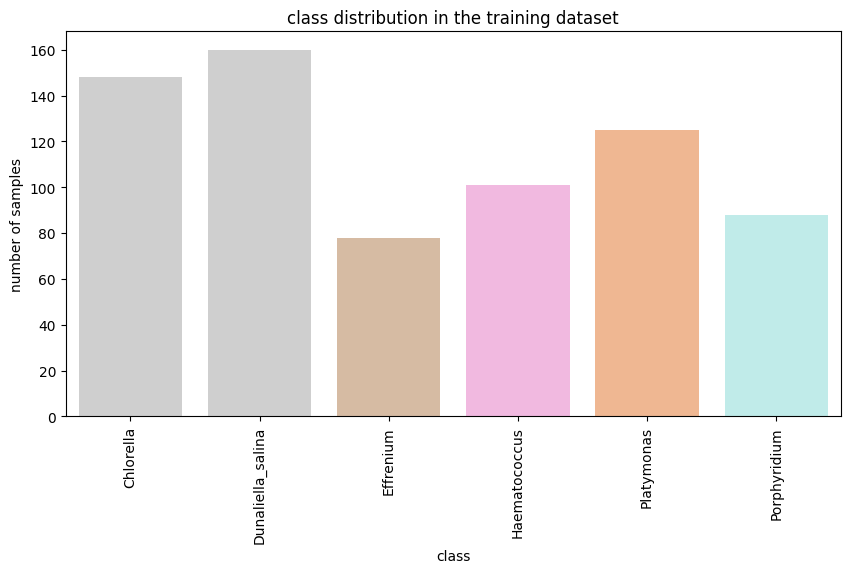

In [61]:
class_indices = train_generator.class_indices

class_names = {v: k for k, v in class_indices.items()}

class_distribution = train_generator.classes

class_names_list = [class_names[class_idx] for class_idx in class_distribution]

plt.figure(figsize=(10, 5))
sns.countplot(x=class_names_list, palette='pastel', order=sorted(class_names_list))
plt.title('class distribution in the training dataset')
plt.xlabel('class')
plt.ylabel('number of samples')
plt.xticks(rotation='vertical')
plt.show()

In [62]:
class_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)

print("class weights")
for class_id, weight in enumerate(class_weights):
    print(f"class- {class_names[class_id]}, weight- {weight}")

class weights
class- Chlorella, weight- 0.7882882882882883
class- Dunaliella_salina, weight- 0.7291666666666666
class- Effrenium, weight- 1.4957264957264957
class- Haematococcus, weight- 1.155115511551155
class- Platymonas, weight- 0.9333333333333333
class- Porphyridium, weight- 1.3257575757575757


In [63]:
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: np.float64(0.7882882882882883),
 1: np.float64(0.7291666666666666),
 2: np.float64(1.4957264957264957),
 3: np.float64(1.155115511551155),
 4: np.float64(0.9333333333333333),
 5: np.float64(1.3257575757575757)}

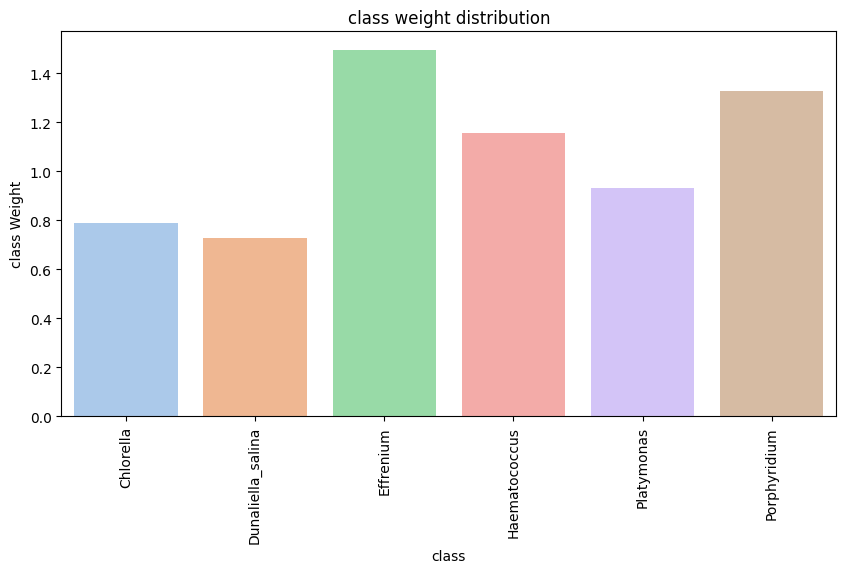

In [64]:
class_weights = [0.78828829, 0.72916667, 1.4957265, 1.15511551, 0.93333333, 1.32575758]
new_class_names = ['Chlorella', 'Dunaliella_salina', 'Effrenium', 'Haematococcus', 'Platymonas', 'Porphyridium']

data = {'Class': new_class_names, 'Weight': class_weights}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Weight', data=df, palette='pastel')
plt.title('class weight distribution')
plt.xlabel('class')
plt.ylabel('class Weight')
plt.xticks(rotation='vertical')
plt.show()

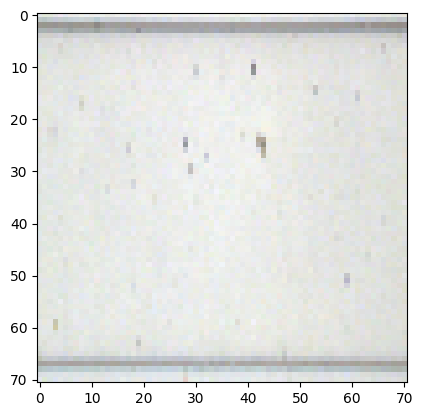

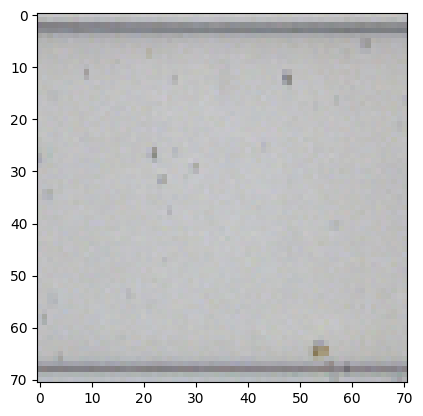

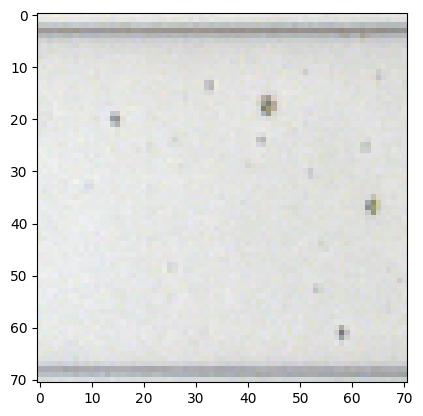

In [66]:
for _ in range(10):
    img, label = next(train_generator)
    if label[0][1] == 1:
        plt.imshow(img[0])
        plt.show()

In [70]:
base_model=ConvNeXtTiny(
    include_top=False,
    include_preprocessing=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(71, 71, 3),
    pooling=None,
    classes=6,
    classifier_activation="softmax",
)

In [69]:
for layer in base_model.layers:
    layer.trainable = False

In [71]:
ConvNeXtTiny_learner=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])

In [72]:
ConvNeXtTiny_learner.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ (None, 2, 2, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,018,534 (106.88 MB)

 Trainable params: 28,018,534 (106.88 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
METRICS = [
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [77]:
ConvNeXtTiny_learner.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'] + METRICS,
)

In [ ]:
ConvNeXtTiny_history=ConvNeXtTiny_learner.fit(train_generator,epochs=100,class_weight=class_weight_dict)

Epoch 1/100
